## if include sensor_id then can fit quite a good model - but this would be a model that would only be able to predict at those locations

In [93]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil

from Functions import *

In [94]:
buffer_size_m = 400
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [95]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=2, random_state=1, shuffle=True)

In [96]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])

### Prepare data for modelling

In [97]:
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

### Remove year

In [98]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']
Xfull['sensor_id'] = sensor_ids
# sensor_dummy =  pd.get_dummies(Xfull['sensor_id'], drop_first = True)
# sensor_dummy.columns= prepend(sensor_dummy.columns.values, 'sensor_')
# Xfull = pd.concat([Xfull, sensor_dummy],axis=1)
# del Xfull['sensor_id']
# Xfull.columns

In [99]:
# del Xfull['year']

### Choose which month_num and weekday_num option to include

In [100]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

### Remove spatial features

In [101]:
Xfull.drop(['transport_stops','betweenness', 'lights', 'street_inf', 'memorials', 'trees','bus-stops', 'tram-stops', 'metro-stations', 
            'taxi-ranks', 'big-car-parks', 'street_inf_Bicycle Rails', 'street_inf_Bollard','street_inf_Drinking Fountain',
            'street_inf_Floral Crate/Planter Box','street_inf_Horse Trough', 'street_inf_Information Pillar',
            'street_inf_Litter Bin', 'street_inf_Seat', 'street_inf_Tree Guard','landmarks_Community Use', 
            'landmarks_Mixed Use','landmarks_Place Of Assembly', 'landmarks_Place of Worship', 'landmarks_Retail', 
            'landmarks_Transport', 'landmarks_Education Centre','landmarks_Leisure/Recreation', 'landmarks_Office',
       'street_inf_Barbeque', 'street_inf_Hoop', 'street_inf_Picnic Setting', 'landmarks_Specialist Residential Accommodation',
       'landmarks_Vacant Land', 'landmarks_Purpose Built','landmarks_Health Services', 'avg_n_floors', 'buildings_Community Use',
       'buildings_Education', 'buildings_Entertainment', 'buildings_Events','buildings_Hospital/Clinic', 'buildings_Office', 'buildings_Parking',
       'buildings_Public Display Area', 'buildings_Residential','buildings_Retail', 'buildings_Storage', 'buildings_Unoccupied',
       'buildings_Working', 'buildings_Transport'], axis=1, inplace = True)

In [105]:
full_data= Xfull.copy()
full_data['counts']= Yfull

In [ ]:
-37.812187461761596, 144.962265054567

In [135]:
predictions_dict = {}
Yfull_dict = {}
mapes = []
# Dataframe to store the scores for all the models
error_metric_scores = pd.DataFrame()

for sensor_id in sensor_ids.unique():
    print(sensor_id)
    one_sensor=full_data[full_data['sensor_id'] == sensor_id]
    Xfull = one_sensor.loc[:, one_sensor.columns != 'counts']
    Yfull = one_sensor['counts']
    
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=cv_parameters, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    predictions = cross_val_predict(model_pipeline, Xfull, Yfull,cv=cv_parameters)
    df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'AbsolouteError':abs(Yfull-predictions)})
    mape = (df['AbsolouteError'].mean()/df['Real_vals'].mean()*100,1)
    print(mape)
    mapes.append(mape)
    
    predictions_dict[sensor_id]=predictions
    Yfull_dict[sensor_id]=Yfull
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[sensor_id])
        
#     # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
#     # Save error scores for this distance to file
#     #error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# # Save dataframes of error metrics for each buffer distance 
# #error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

8
Ran in 0 minutes
(17.98961460476141, 1)
2
Ran in 0 minutes
(14.352368540836366, 1)
15
Ran in 0 minutes
(12.21135019552715, 1)
18
Ran in 0 minutes
(15.794402123080872, 1)
9
Ran in 0 minutes
(18.96297248036497, 1)
10
Ran in 0 minutes
(21.39179938338733, 1)
14
Ran in 0 minutes
(16.81479986975949, 1)
17
Ran in 0 minutes
(15.530902854473142, 1)
13
Ran in 0 minutes
(16.875132820284993, 1)
16
Ran in 0 minutes
(11.755545964705547, 1)
7
Ran in 0 minutes
(48.143382813623624, 1)
11
Ran in 0 minutes
(35.50725346461074, 1)
12
Ran in 0 minutes
(28.89531395287637, 1)
3
Ran in 0 minutes
(12.583341508270118, 1)
5
Ran in 0 minutes
(17.74921766529121, 1)
4
Ran in 0 minutes
(16.463694091311282, 1)
6
Ran in 0 minutes
(13.501835306295279, 1)
1
Ran in 0 minutes
(15.774030135013826, 1)
24
Ran in 0 minutes
(14.282660798220071, 1)
27
Ran in 0 minutes
(17.53082349183156, 1)
19
Ran in 0 minutes
(12.991273035997185, 1)
25
Ran in 0 minutes
(21.312034298059032, 1)
22
Ran in 0 minutes
(13.434109527445685, 1)
21
Ran

In [116]:
predictions = predictions_dict[15]
Yfull =Yfull_dict[15]
fig, ax = plt.subplots(ncols=1, figsize = (7,4))
# Plot with log scale
using_datashader(ax, Yfull, predictions, 'log')
ax.plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
ax.set_ylabel("Predicted Values", size=10)
ax.set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
ax.tick_params(axis='both', which='major', labelsize=8)
plt.show()    

KeyError: 15

### Run model with cross validation

### Print table showing error metrics associated with each model

In [142]:
mapes[:50]
test= mapes.copy()
new_mapes = []
for mape in mapes:
    new_mapes.append(mape[0])

In [28]:
#### Run cross_val_predict to get predictions
start = time()
predictions = cross_val_predict(model_pipeline, Xfull, Yfull,cv=cv_parameters)
end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

Ran cross_val_predict in 5 minutes


In [29]:
# Convert to a dataframe
predictions_df=pd.DataFrame(predictions)
# Store the predictions
# predictions_df.to_csv('Results/CV/RF_500m/predictions.csv',index=False)   

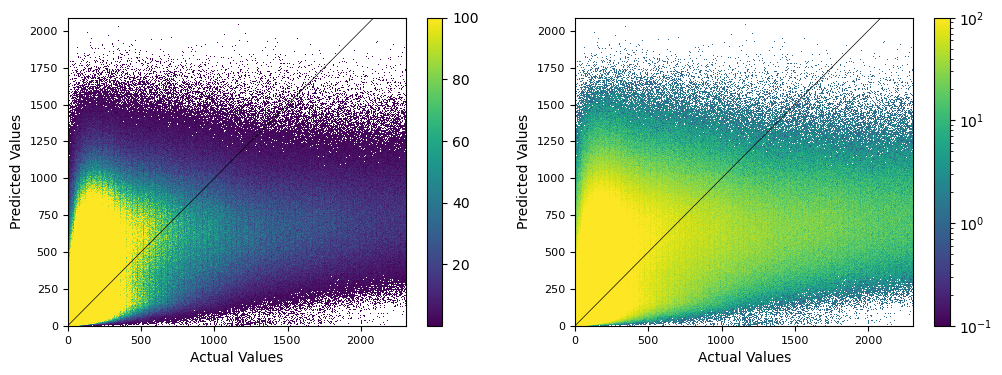

In [31]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], Yfull, predictions, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], Yfull, predictions, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

In [133]:
df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'AbsolouteError':abs(Yfull-predictions)})
(df['AbsolouteError'].mean()/df['Real_vals'].mean()*100,1)

(14.573475349670737, 1)

In [ ]:
one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)

In [127]:
# Get all relevant data in one dataframe
df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num'] ,'Sensor_id':sensor_ids, 'AbsolouteError':abs(Yfull-predictions)})
# Add hour of week variable
df['hour_of_week'] = df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
df=df.sort_values(by=['Weekday', 'Hour'])
df.head()

ValueError: array length 2952 does not match index length 4129082

In [ ]:

sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

# Loop through the sensors and add the results to the list
for sensor_id in sensor_ids.unique():
    # print("At sensor {}".format(sensor_id))
    one_sensor = df[df['Sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

In [120]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

In [156]:
sensorly_errors_df

,sensor_id,error
0,8,17.989615
1,2,14.352369
2,15,12.211350
3,18,15.794402
4,9,18.962972
...,...,...
77,79,19.366462
78,85,15.457123
79,84,11.878040
80,86,19.068321


In [162]:
sensorly_errors_df = pd.DataFrame({'sensor_id':sensor_ids.unique(),'error':new_mapes})
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')


In [163]:
melbourne_sensors

,sensor_id,error,Name,sensor_name,installation_date,status,note,direction_1,direction_2,Latitude,Longitude,location
0,8,17.989615,Webb Bridge,WebBN_T,24/03/2009,A,NaN,South,North,-37.822935,144.947175,"(-37.82293543, 144.94717511)"
1,2,14.352369,Bourke Street Mall (South),Bou283_T,30/03/2009,A,NaN,East,West,-37.813807,144.965167,"(-37.81380667, 144.96516719)"
2,15,12.211350,State Library,QV_T,25/03/2009,R,NaN,South,North,-37.810644,144.964471,"(-37.81064378, 144.96447132)"
3,18,15.794402,Collins Place (North),Col12_T,30/03/2009,A,NaN,East,West,-37.813449,144.973053,"(-37.81344861, 144.97305354)"
4,9,18.962972,Southern Cross Station,Col700_T,23/03/2009,A,NaN,East,West,-37.819830,144.951026,"(-37.81982992, 144.95102556)"
...,...,...,...,...,...,...,...,...,...,...,...,...
77,79,19.366462,Flinders St (South),FliSS_T,10/09/2021,A,NaN,East,West,-37.817940,144.966167,"(-37.81794046, 144.96616678)"
78,85,15.457123,Macaulay Rd (North),488Mac_T,21/12/2021,A,NaN,East,West,-37.794324,144.929734,"(-37.79432414, 144.92973379)"
79,84,11.878040,Elizabeth St - Flinders St (East) - New footpath,ElFi_T,03/12/2021,A,NaN,South,North,-37.817980,144.965034,"(-37.81798049, 144.96503383)"
80,86,19.068321,Queensberry St - Errol St (South),574Qub_T,21/12/2021,A,NaN,East,West,-37.803100,144.949081,"(-37.80309992, 144.94908064)"


In [165]:
# linear = cm.linear.viridis.scale(melbourne_sensors['error'].min(),melbourne_sensors['error'].max()).to_step(7)
# f = folium.Figure(width=700, height=600)
# # Plot
# melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
#                            melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)

# for _, row in melbourne_sensors.iterrows():
#     folium.CircleMarker([row.Latitude, row.Longitude],
#                       popup=row.sensor_id,
#                       radius=8,  fill=True, fill_opacity = 1,
#                       color = linear(row.error), fill_color = linear(row.error),
#                       ).add_to(melbourne_map)

# # folium.TileLayer('stamentoner').add_to(melbourne_map)
# folium.TileLayer('cartodbpositron').add_to(melbourne_map)
# linear.caption = "Mean hourly values"
# svg_style = '<style>svg#legend {background-color: white;}</style>'
# melbourne_map.get_root().header.add_child(folium.Element(svg_style))
# linear.add_to(melbourne_map)

# img_data = melbourne_map._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save('Results/Figs/SpatialErrors_mean.png')

melbourne_map